In [1]:
import polars as pl
import polars_ds as pds
import polars_xdt as xdt
import polars.selectors as cs
import seaborn as sns
from utils import prep,dato_mapping_pub_trening,datoformat_mapping
import matplotlib.pyplot as plt
from datetime import date


c:\Users\Yafee Ishraq\AppData\Local\Programs\Python\Python311\Lib\site-packages\matplotlib\projections\__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


# Les inn data 

In [2]:
df = pl.read_excel("treningsdata.xlsx")
df.head()


Dato,Navn,Deltok,Avlyst trening
i64,str,str,str
20240106,"""Erlend Haukefer Hauan""","""Ja""","""Ja"""
20240106,"""Bakary Jang Konateh""","""Ja""","""Ja"""
20240106,"""Sindre Haukefer Hauan""","""Ja""","""Ja"""
20240204,"""Yafee Ishraq""","""Nei""","""Ja"""
20240204,"""Erlend Haukefer Hauan""","""Nei""","""Ja"""


In [3]:
df = (df
.pipe(datoformat_mapping)
.pipe(dato_mapping_pub_trening)
.pipe(prep)
)


In [4]:
andel_endring = (
df
.filter(pl.col('Avlyst trening')=='Nei',
        pl.col('År')==2025)
.group_by('Navn','Måned navn','Måned')
.agg(pl.col('Treningsdato').filter(pl.col('Deltok')=='Ja').n_unique().alias('Antall treninger'))
.sort(by = ['Navn','Måned'])
.with_columns(pl.col('Antall treninger')
              .filter(pl.col('Måned')<=6)
              .sum().over('Navn')
              .alias('Treninger første halvår'),

              pl.col('Antall treninger')
              .filter(pl.col('Måned')>6)
              .sum().over('Navn')
              .alias('Treninger andre halvår')
              )

.with_columns(cs.numeric().cast(pl.Float64))
.with_columns( 


    (
        (pl.col("Treninger andre halvår") - pl.col("Treninger første halvår"))
        / pl.col("Treninger første halvår")
    ).alias("andel_endring")

)
.filter(pl.col('Treninger første halvår')>0,pl.col('Treninger andre halvår')>=0
        )
#.filter(pl.col('andel_endring')<0)

#.filter(pl.col('Treninger første halvår')>0)

#.select(pl.col('andel_endring').min())
#.filter(pl.col('andel_endring')==pl.col('andel_endring').min())

)

pl.Config.set_tbl_rows(100)
(
andel_endring
.filter(pl.col('Treninger første halvår')>5)
.select('Navn',pl.col('andel_endring').alias('Andel endring'))
.unique()
.sort(by = 'Andel endring',descending=True)

)

Navn,Andel endring
str,f64
"""Shewit Weldeslasie""",0.142857
"""Johannes Aarra""",-0.1
"""Sindre Jakobsen""",-0.230769
"""Carlos Tveit""",-0.3125
"""Jonas Tron Hatlem""",-0.333333
"""Sindre Haukefer Hauan""",-0.470588
"""Markus Bjånesøy""",-0.5625
"""Erlend Haukefer Hauan""",-0.615385
"""Stian Nyheim""",-0.631579


In [21]:

(df
.filter(pl.col('År').is_in([2024,2025]))
.group_by('År')
.agg(pl.col('Dato')
     .filter(pl.col('Avlyst trening')=='Nei')
     .n_unique()
     .alias('Antall arrangerte treninger'),
     
     pl.col('Dato')
     .filter(pl.col('Avlyst trening')=='Ja')
     .n_unique()
     .alias('Antall avlyste treninger'),

     pl.col('Dato')
     .n_unique()
     .alias('Antall planlagte treninger')

     )
.with_columns(pl.col('Antall arrangerte treninger').shift(-1).alias('Forrige år arrangerte treninger'))
.with_columns(pl.lit(1).sub(pl.col('Antall arrangerte treninger')/pl.col('Forrige år arrangerte treninger')).alias('Endring i andel arrangerte treninger'))
.sort(by='År')
)

År,Antall arrangerte treninger,Antall avlyste treninger,Antall planlagte treninger,Forrige år arrangerte treninger,Endring i andel arrangerte treninger
i32,u32,u32,u32,u32,f64
2024,19,17,35,null,null
2025,32,11,43,19,-0.684211


In [35]:

(df
.filter(pl.col('År').is_in([2024,2025]))
.group_by('Navn','År')
.agg(pl.col('Dato')
     .filter(pl.col('Avlyst trening')=='Nei',
             pl.col('Deltok')=='Ja')
     .n_unique()
     .alias('Antall treninger'),

     pl.col('Dato')
     .n_unique()
     .alias('Antall stemmer')

     )

.sort(by=['Navn','År'],descending=[True,False])
.with_columns(pl.col('Antall treninger').shift(1).over('Navn').alias('Antall treninger forrige år'))
.with_columns((pl.col('Antall treninger')/pl.col('Antall treninger forrige år')).sub(pl.lit(1)).alias('Endring i andel treninger'))

    
)

Navn,År,Antall treninger,Antall stemmer,Antall treninger forrige år,Endring i andel treninger
str,i32,u32,u32,u32,f64
"""Yaser Almohamad""",2025,0,2,null,null
"""Yafee Ishraq""",2024,15,31,null,null
"""Yafee Ishraq""",2025,18,38,15,0.2
"""Tobias Skjæveland""",2025,0,2,null,null
"""Thomas Thorbjørnsen""",2024,8,33,null,null
"""Thomas Thorbjørnsen""",2025,0,41,8,-1.0
"""Thomas Syversen""",2024,1,1,null,null
"""Thomas Iyob""",2025,7,8,null,null
"""Stian Nyheim""",2024,11,25,null,null


In [13]:
andel_endring

Navn,Måned navn,Måned,Antall treninger,Treninger første halvår,Treninger andre halvår,andel_endring
str,str,f64,f64,f64,f64,f64
"""Adrian Torvund""","""Januar""",1.0,1.0,4.0,5.0,0.25
"""Adrian Torvund""","""Februar""",2.0,2.0,4.0,5.0,0.25
"""Adrian Torvund""","""Mars""",3.0,1.0,4.0,5.0,0.25
"""Adrian Torvund""","""April""",4.0,0.0,4.0,5.0,0.25
"""Adrian Torvund""","""Mai""",5.0,0.0,4.0,5.0,0.25
"""Adrian Torvund""","""Juni""",6.0,0.0,4.0,5.0,0.25
"""Adrian Torvund""","""September""",9.0,2.0,4.0,5.0,0.25
"""Adrian Torvund""","""Oktober""",10.0,3.0,4.0,5.0,0.25
"""Adrian Torvund""","""November""",11.0,0.0,4.0,5.0,0.25


In [25]:
(andel_endring
.group_by('Navn',
          pl.when(pl.col('Måned')<=6)
          .then(pl.lit('Første halvår'))
          .otherwise(pl.lit('Andre halvår'))
          .alias('Periode')
          )
.agg(pl.col('Antall treninger').sum().alias('Antall treninger per periode'))
#.sort(by = ['Totalt antall treninger','Navn','Periode'],descending=True)
.pivot(index = 'Navn',on = 'Periode',values = 'Antall treninger per periode')
.with_columns(pl.sum_horizontal(cs.numeric()).alias('Totalt antall treninger'))
.sort(by = 'Totalt antall treninger',descending=True)
)

Navn,Første halvår,Andre halvår,Totalt antall treninger
str,f64,f64,f64
"""Carlos Tveit""",16.0,11.0,27.0
"""Sindre Haukefer Hauan""",17.0,9.0,26.0
"""Stian Nyheim""",19.0,7.0,26.0
"""Markus Bjånesøy""",16.0,7.0,23.0
"""Sindre Jakobsen""",13.0,10.0,23.0
"""Sami Bwoy IV""",15.0,5.0,20.0
"""Johannes Aarra""",10.0,9.0,19.0
"""Yafee Ishraq""",14.0,4.0,18.0
"""Erlend Haukefer Hauan""",13.0,5.0,18.0


<Axes: xlabel='andel_endring', ylabel='Count'>

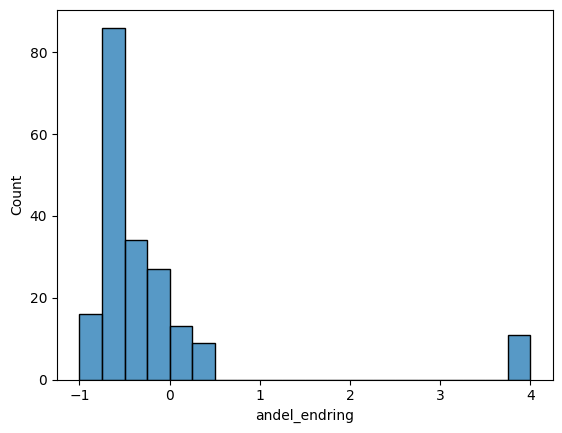

In [88]:
sns.histplot(data=andel_endring.filter(pl.col('Treninger første halvår')>0).to_pandas(), x="andel_endring", bins=20)

In [27]:
df_ml = (df
.group_by('Treningsdato','Avlyst trening')
.agg(pl.col('Navn').filter(pl.col('Deltok').eq('Ja')).n_unique().alias('y'))
.with_columns(pl.when(pl.col('Avlyst trening')=='Ja').then(pl.lit(0)).otherwise(pl.col('y')).name.keep())
.sort(by = ['Treningsdato'])
.with_row_index(name = 'ds',offset = 1)

)

df_ml_train  = df_ml.filter(pl.col('Treningsdato')<pl.col('Treningsdato').max())

In [28]:
df_ml_train

ds,Treningsdato,Avlyst trening,y
u32,date,str,u32
1,2024-01-08,"""Ja""",0
2,2024-02-05,"""Ja""",0
3,2024-02-19,"""Nei""",7
4,2024-02-26,"""Nei""",12
5,2024-03-04,"""Ja""",0
…,…,…,…
53,2025-05-14,"""Nei""",12
54,2025-05-21,"""Nei""",8
55,2025-05-28,"""Nei""",11


INFO:nixtla.nixtla_client:Happy Forecasting! :)


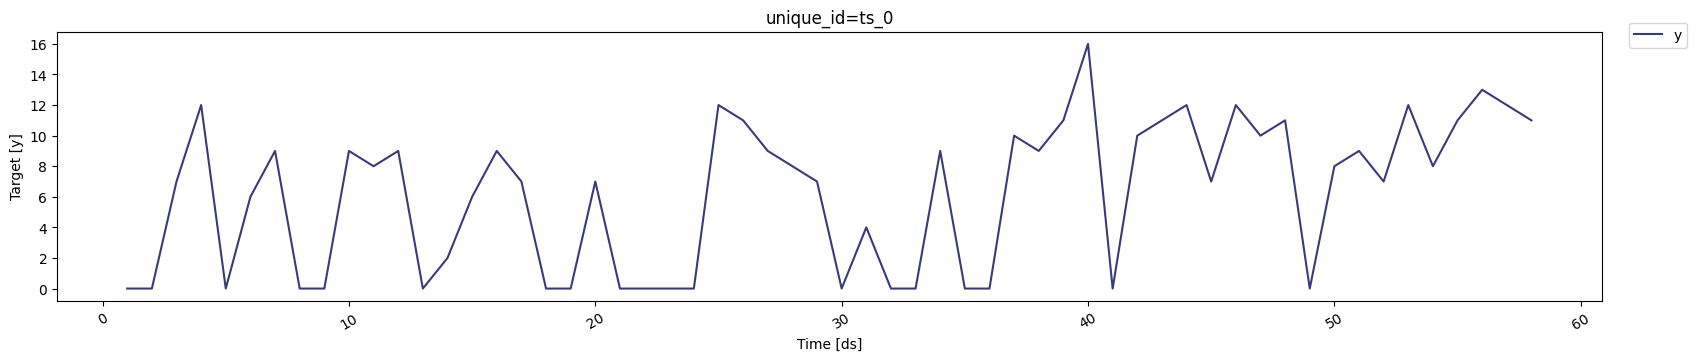

In [29]:
from nixtla import NixtlaClient

nixtla_client = NixtlaClient(
    api_key='nixak-0xcm0Pp1p1wYaiDgeUh0z05Rsw57UKqrO5wYk5GuaSOFLPRseTGHGEHAtRcHoPjLVSzHIdq5jKlA8RVw'
)

nixtla_client.validate_api_key()

nixtla_client.plot(df_ml, time_col='ds', target_col='y')


In [42]:

timegpt_fcst_df = nixtla_client.forecast(
    df=df_ml,
    h=1,
    freq=1,
    time_col='ds',
    target_col='y'
)

timegpt_fcst_df.rename({'TimeGPT':'Predikert antall på trening'}).head()

INFO:nixtla.nixtla_client:Validating inputs...
c:\Users\Yafee Ishraq\AppData\Local\Programs\Python\Python311\Lib\site-packages\nixtla\nixtla_client.py:383: UserWarning: `df` contains the following exogenous features: ['Treningsdato', 'Avlyst trening'], but `X_df` was not provided and they were not declared in `hist_exog_list`. They will be ignored.
  warnings.warn(
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Restricting input...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


ds,Predikert antall på trening
i64,f64
59,11.223002


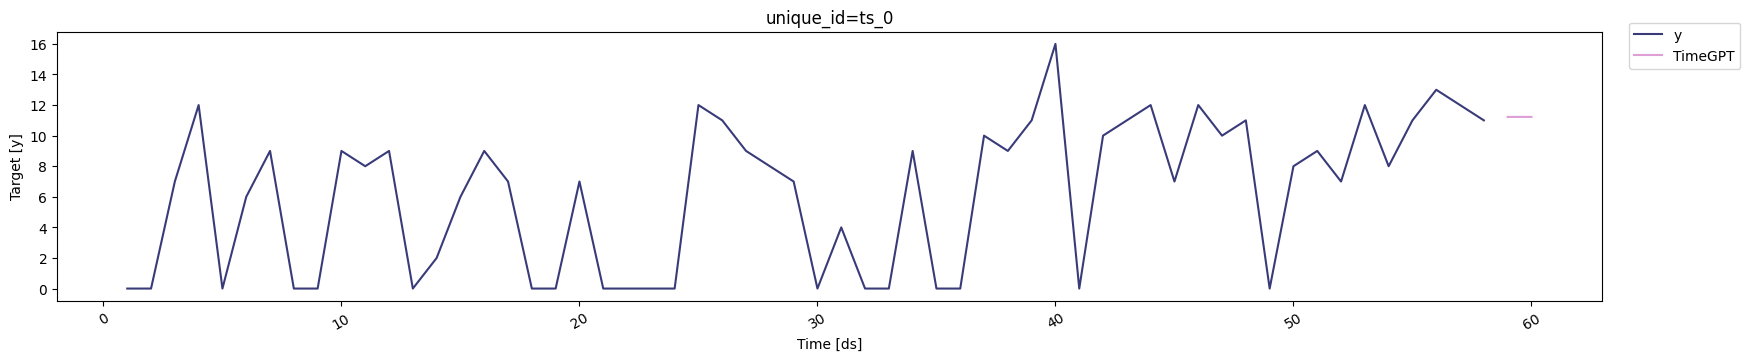

In [39]:
nixtla_client.plot(df_ml, timegpt_fcst_df, time_col='ds', target_col='y')

In [32]:
alle_unike_datoer = df.select('Dato','Treningsdato').unique()
alle_unike_navn = df.select('Navn').unique()

# Joiner alle mulige stemmedatoer, vi skal få inn nei på de datoene det ikke er stemt på 
alle_unike_datoer_navn = alle_unike_datoer.join(other=alle_unike_navn, how='cross')
alle_unike_datoer_navn

Dato,Treningsdato,Navn
date,date,str
2024-01-06,2024-01-08,"""Stian Nyheim"""
2024-01-06,2024-01-08,"""Thomas Thorbjørnsen"""
2024-01-06,2024-01-08,"""Maria Håland Alvik"""
2024-01-06,2024-01-08,"""Sami Bwoy IV"""
2024-01-06,2024-01-08,"""Bjørn Nilsen"""
…,…,…
2025-05-04,2025-05-07,"""Magnus Alexander Gjerde Bevan"""
2025-05-04,2025-05-07,"""Rodas Breezy"""
2025-05-04,2025-05-07,"""Håkon Halvorsen"""


In [33]:
alle_unike_datoer_navn.filter(pl.col('Treningsdato').dt.year()==2025,pl.col('Navn').str.contains('Magnus Jensen')).sort(by = ['Treningsdato'])

Dato,Treningsdato,Navn
date,date,str
2025-01-20,2025-01-22,"""Magnus Jensen"""
2025-01-26,2025-01-29,"""Magnus Jensen"""
2025-02-03,2025-02-05,"""Magnus Jensen"""
2025-02-09,2025-02-12,"""Magnus Jensen"""
2025-02-18,2025-02-19,"""Magnus Jensen"""
…,…,…
2025-04-27,2025-04-30,"""Magnus Jensen"""
2025-05-04,2025-05-07,"""Magnus Jensen"""
2025-05-11,2025-05-14,"""Magnus Jensen"""


In [37]:
# DETTE GIR FEIL BILDE
(df
.join(other = alle_unike_datoer_navn, on=['Treningsdato','Dato','Navn'],
       how='full',coalesce=True)
.with_columns(pl.col('Avlyst trening').fill_null(pl.col('Avlyst trening').max().over('Dato')))
.with_columns(pl.col('Deltok').fill_null('Nei'))
.filter(pl.col('Navn').str.contains('Magnus Jensen'))
)

Dato,Navn,Deltok,Avlyst trening,Treningsdato,År,Måned,Dag,Måned navn,Årstid
date,str,str,str,date,i32,i8,i8,str,str
2024-01-06,"""Magnus Jensen""","""Nei""","""Ja""",2024-01-08,null,null,null,null,null
2024-02-04,"""Magnus Jensen""","""Nei""","""Ja""",2024-02-05,2024,2,1,"""Februar""","""vinter"""
2025-04-06,"""Magnus Jensen""","""Nei""","""Nei""",2025-04-09,null,null,null,null,null
2024-04-01,"""Magnus Jensen""","""Nei""","""Ja""",2024-04-01,null,null,null,null,null
2024-10-02,"""Magnus Jensen""","""Nei""","""Ja""",2024-10-07,null,null,null,null,null
…,…,…,…,…,…,…,…,…,…
2024-02-24,"""Magnus Jensen""","""Nei""","""Nei""",2024-02-26,null,null,null,null,null
2024-07-06,"""Magnus Jensen""","""Nei""","""Ja""",2024-07-08,null,null,null,null,null
2024-05-12,"""Magnus Jensen""","""Nei""","""Nei""",2024-05-13,null,null,null,null,null


In [42]:
pl.Config.set_tbl_rows(25)

# Dette gir egentlig feil bilde. Må finne punktet mellom 2 treninger og ta disansen mellom dem.
(df
.sort(by = ['Navn','Dato'])
.filter(pl.col('Avlyst trening')=='Nei',
        pl.col('Deltok')=='Ja'
        )
.with_columns(pl.col('Dato').shift(1).over('Navn').alias('Forrige trening'))
.drop_nulls('Forrige trening')

.with_columns(xdt.month_delta('Forrige trening','Dato').alias('Antall måneder'))
.group_by('Navn','År')
.agg(pl.col('Antall måneder').mean().alias('Gjennomsnittlig antall måneder mellom treninger'))
.sort(by = ['Gjennomsnittlig antall måneder mellom treninger'])
.filter(pl.col('År')==2025)
)

Navn,År,Gjennomsnittlig antall måneder mellom treninger
str,i32,f64
"""Sami Bwoy IV""",2025,0.0
"""Jonas Tron Hatlem""",2025,0.0
"""Stian Nyheim""",2025,0.125
"""Sindre Haukefer Hauan""",2025,0.153846
"""Carlos Tveit""",2025,0.153846
"""Shewit Weldeslasie""",2025,0.166667
"""Yafee Ishraq""",2025,0.166667
"""Rodas Breezy""",2025,0.166667
"""Sindre Jakobsen""",2025,0.25


In [12]:
treningsstreak = (df
.filter(pl.col('Avlyst trening')=='Nei',
        pl.col('Navn')=='Sindre Haukefer Hauan',
        pl.col('År')==2025
        )       
.group_by('Navn')
.agg(pl.col('Dato').filter(pl.col('Deltok')=='Ja').n_unique().alias('Totalt antall treninger'),
     pl.col('Dato').filter(pl.col('Deltok')=='Ja').min().cast(pl.Date).alias('Første trening'),
     pl.col('Dato').filter(pl.col('Deltok')=='Ja').max().cast(pl.Date).alias('Siste trening'),
     pds.query_longest_streak(pl.col('Deltok')=='Ja').alias('Streak')
     )
)

treningsstreak

Navn,Totalt antall treninger,Første trening,Siste trening,Streak
str,u32,date,date,u32
"""Sindre Haukefer Hauan""",12,2025-01-20,2025-04-27,6


c:\Users\Yafee Ishraq\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\Yafee Ishraq\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


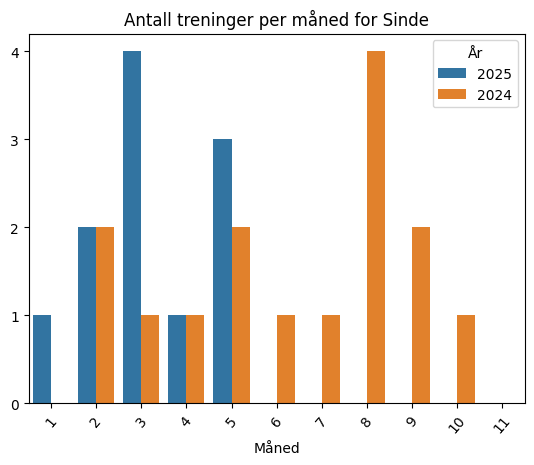

In [28]:
aar = 2025

from matplotlib.ticker import MaxNLocator

# Henter ut sortert liste over måneder
maaned_sort = df.select('Måned', 'Måned navn').unique().sort(by ='Måned',descending=False)['Måned'].to_list()

topp_10 = (df
.filter(pl.col('Avlyst trening')=='Nei',
        pl.col('Deltok')=='Ja',
        pl.col('Navn')=='Yafee Ishraq',
        pl.col('År').is_in([aar,aar-1])
        )
.group_by('Navn','År','Måned')
.agg(pl.col('Dato').n_unique().cast(pl.Int64).alias('Antall treninger'))
.sort(by = ['Måned','År'],descending=[False,False])
.with_columns(pl.col(['Måned', 'År']).cast(pl.Utf8))
)

fig, ax = plt.subplots()
sns.barplot(data=topp_10.to_pandas(), x='Måned', y='Antall treninger',hue = 'År',ax = ax,order=maaned_sort)
ax.set_title(f'Antall treninger per måned for Sinde')
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
ax.set(ylabel=None) 

# Roter x-labels
ax.tick_params(axis='x', rotation=50)


In [7]:
(df
.filter(pl.col('Treningsdato').dt.year()==2024,
        pl.col('Treningsdato').dt.month()==9
        )
.group_by('Måned')
.agg( 
      pl.when(pl.col('Treningsdato').filter(pl.col('Avlyst trening')=='Nei').n_unique()==1)
      .then(
      pl.col('Navn')
      .filter(pl.col('Deltok')=='Ja')
      .n_unique()
      )
      .otherwise(
      pl.col('Navn')
      .filter(pl.col('Deltok')=='Ja')
      .len()
      .truediv(pl.col('Treningsdato').filter(pl.col('Avlyst trening')=='Nei').n_unique())
     )
     .alias('Antall per trening')
     )
)

Måned,Antall per trening
i8,f64
9,5.5


In [6]:
df

Dato,Navn,Deltok,Avlyst trening,Treningsdato,År,Måned,Dag,Måned navn,Årstid
date,str,str,str,date,i32,i8,i8,str,str
2024-01-06,"""Erlend Haukefer Hauan""","""Ja""","""Ja""",2024-01-08,2024,1,1,"""Januar""","""vinter"""
2024-01-06,"""Bakary Jang Konateh""","""Ja""","""Ja""",2024-01-08,2024,1,1,"""Januar""","""vinter"""
2024-01-06,"""Sindre Haukefer Hauan""","""Ja""","""Ja""",2024-01-08,2024,1,1,"""Januar""","""vinter"""
2024-02-04,"""Yafee Ishraq""","""Nei""","""Ja""",2024-02-05,2024,2,1,"""Februar""","""vinter"""
2024-02-04,"""Erlend Haukefer Hauan""","""Nei""","""Ja""",2024-02-05,2024,2,1,"""Februar""","""vinter"""
…,…,…,…,…,…,…,…,…,…
2025-05-18,"""Magnus Alexander Gjerde Bevan""","""Ja""","""Nei""",2025-05-21,2025,5,3,"""Mai""","""vår"""
2025-05-18,"""Johannes Aarra""","""Ja""","""Nei""",2025-05-21,2025,5,3,"""Mai""","""vår"""
2025-05-18,"""Markus Bjånesøy""","""Ja""","""Nei""",2025-05-21,2025,5,3,"""Mai""","""vår"""


In [12]:
(df
.select('Dato','Måned nr','Måned')
.filter(pl.col('Dato').dt.year()==2024,pl.col('Dato').dt.month()==9)

)

Dato,Måned nr,Måned
date,i8,str
2024-09-02,8,"""August"""
2024-09-02,8,"""August"""
2024-09-02,8,"""August"""
2024-09-02,8,"""August"""
2024-09-02,8,"""August"""
…,…,…
2024-09-09,9,"""September"""
2024-09-09,9,"""September"""
2024-09-09,9,"""September"""


In [10]:
# Skal koble på den første mandagen etter publiseringsdato

# Henter ut max og min dato
aar_max = int(df.select('År').max().item())
aar_min = int(df.select('År').min().item())

alle_datoer = pl.DataFrame({'alle_dato':pl.date_range(date(aar_min, 1, 1), date(aar_max, 12, 1), "1d", eager=True)})

publiseringsdato = df.select('Dato').unique().rename({'Dato':'publiseringsdato'})


In [ ]:
publiseringsdato = (publiseringsdato

# Kobler på alle datoer som er større enn publiseringsdato
.join_where(
alle_datoer,

# Denne inequalitien vil sikre at dersom èn har publisert trening samme dag som det skal være trening
pl.col('publiseringsdato')<=pl.col('alle_dato')
)

# Ekstraherer ukedag
.with_columns(pl.col('alle_dato').dt.weekday().alias('dag'))

# Identifiserer hva som er den første mandagen ellers onsdag
 .group_by('publiseringsdato')
 .agg(
     
    # Første mandag  
    pl.col('alle_dato').filter(pl.col('dag')==1).min().alias('forste_mandag'),

    # Første onsdag
    pl.col('alle_dato').filter(pl.col('dag')==3).min().alias('forste_onsdag')
    
    )

# Dersom det er 2024 brukes mandag, hvis ikke brukes onsdag. Må sannsynligvis endre på logikken om flere år inkluderes i datasettet
.with_columns(pl.when(pl.col('publiseringsdato').dt.year()==2024)
              .then(pl.col('forste_mandag'))
              .otherwise(pl.col('forste_onsdag'))
              .alias('treningsdato')
)

# Fjerner forste_ kolonnene
.select(~cs.starts_with('forste'))

# Det kan være tilfeller hvor treningsdato har to eller flere publiseringsdato. Dette kan for eksempel forekomme dersom èn har publisert trening to ganger etter første mandagen i uken, som foreksempel
# 2024-07-25 (torsdag) og 2024-07-28 (søndag). Derfor tas det unike radene av treningsdato
.unique(subset='treningsdato')

)



# Må ta en inner join fordi vi fjerner duplikater av tilfeller hvor treningsdato har 2 eller flere publiseringsdato
df = (df
.join(other = publiseringsdato,left_on='Dato',right_on='publiseringsdato',how = 'inner')
.drop('Dato')
.rename({'treningsdato':'Dato'})
)


Navn,Deltok,Avlyst trening,År,Måned,Dag,Måned nr,Dato
str,str,str,str,str,i64,i64,date
"""Erlend Haukefer Hauan""","""Ja""","""Ja""","""2024""","""Januar""",6,1,2024-01-08
"""Bakary Jang Konateh""","""Ja""","""Ja""","""2024""","""Januar""",6,1,2024-01-08
"""Sindre Haukefer Hauan""","""Ja""","""Ja""","""2024""","""Januar""",6,1,2024-01-08
"""Yafee Ishraq""","""Nei""","""Ja""","""2024""","""Februar""",4,2,2024-02-05
"""Erlend Haukefer Hauan""","""Nei""","""Ja""","""2024""","""Februar""",4,2,2024-02-05
…,…,…,…,…,…,…,…
"""Magnus Alexander Gjerde Bevan""","""Ja""","""Nei""","""2025""","""Mai""",18,5,2025-05-21
"""Johannes Aarra""","""Ja""","""Nei""","""2025""","""Mai""",18,5,2025-05-21
"""Markus Bjånesøy""","""Ja""","""Nei""","""2025""","""Mai""",18,5,2025-05-21


In [9]:
(df
.group_by('Navn','Måned')
.agg(pds.query_longest_streak(pl.col('Deltok')=='Ja').alias('Streak'))
#.filter(pl.col('Navn').str.contains('Erlend'))
.sort(by = 'Streak')
)

Navn,Måned,Streak
str,str,u32
"""Carlos Tveit""","""September""",0
"""Patrick Waage Seljenes""","""Oktober""",0
"""Thomas Thorbjørnsen""","""Mai""",0
"""Patrick Waage Seljenes""","""Juni""",0
"""Ruben André M. Njøtøy""","""Mai""",0
…,…,…
"""Sindre Jakobsen""","""April""",4
"""Sindre Jakobsen""","""August""",5
"""Thomas Thorbjørnsen""","""August""",5


In [44]:
pl.Config(tbl_rows=50)
df.filter(pl.col('Navn')=='Erlend Haukefer Hauan')

Dato,Navn,Deltok,Avlyst trening,År,Måned,Dag,Måned nr
date,str,str,str,str,str,i64,i64
2024-01-06,"""Erlend Haukefer Hauan""","""Ja""","""Ja""","""2024""","""Januar""",6,1
2024-02-04,"""Erlend Haukefer Hauan""","""Nei""","""Ja""","""2024""","""Februar""",4,2
2024-02-17,"""Erlend Haukefer Hauan""","""Nei""","""Nei""","""2024""","""Februar""",17,2
2024-02-24,"""Erlend Haukefer Hauan""","""Ja""","""Nei""","""2024""","""Februar""",24,2
2024-03-02,"""Erlend Haukefer Hauan""","""Ja""","""Ja""","""2024""","""Mars""",2,3
2024-03-08,"""Erlend Haukefer Hauan""","""Ja""","""Nei""","""2024""","""Mars""",8,3
2024-04-20,"""Erlend Haukefer Hauan""","""Ja""","""Nei""","""2024""","""April""",20,4
2024-04-28,"""Erlend Haukefer Hauan""","""Ja""","""Nei""","""2024""","""April""",28,4
2024-05-05,"""Erlend Haukefer Hauan""","""Ja""","""Ja""","""2024""","""Mai""",5,5


<Axes: xlabel='Antall treninger', ylabel='Count'>

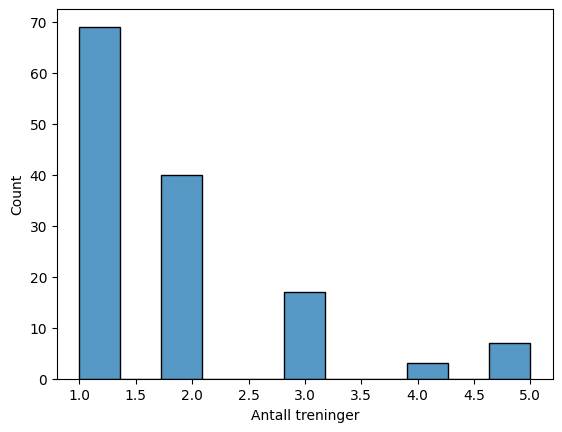

In [36]:
antall_treninger_deltaker = df.filter(pl.col('Avlyst trening')=='Nei').group_by('Navn','Måned').agg(pl.col('Dato').n_unique().alias('Antall treninger'))

fig, ax = plt.subplots()
sns.histplot(data = antall_treninger_deltaker.to_pandas(),x='Antall treninger',ax = ax)

# Roter x-labels
#ax.tick_params(axis='x', rotation=50)
#ax.set_ylabel("")
#ax.yaxis.set_major_locator(MaxNLocator(integer=True))
#ax.set_title('Antall treninger per måned')

In [30]:
antall_treninger.filter(pl.col('Måned')=='April')

Måned,variable,value
str,str,u32
"""April""","""Antall avlyste treninger""",3
"""April""","""Antall treninger""",3


In [6]:
(df
.group_by('Navn')
.agg(
     pl.col('Dato').filter(pl.col('Deltok')=='Ja').n_unique().alias('Antall treninger'),
     pl.col('Dato')
     .filter(pl.col('Deltok')=='Ja')
     .n_unique()
     .truediv(pl.col('Dato').n_unique())
     .alias('Andel treninger'))
#.sort(by = ['Antall treninger'])
)

Navn,Antall treninger,Andel treninger
str,u32,f64
"""Håkon Halvorsen""",1,0.5
"""Magnus Alexander Gjerde Bevan""",2,0.5
"""Ahmed Abusaada""",4,0.8
"""Markus Bjånesøy""",4,0.210526
"""Helge Håvås""",5,0.833333
…,…,…
"""Adrian S.Larsen""",2,0.5
"""Magnus Jensen""",0,0.0
"""Sondre Foldenes Gangdal""",0,0.0


In [18]:
df.sort(by = ['Navn', 'Dato'])

Dato,Navn,Deltok,Avlyst trening,År,Måned,Dag,Måned nr
date,str,str,str,str,str,i64,i64
2024-02-17,"""Adrian S.Larsen""","""Ja""","""Nei""","""2024""","""Februar""",17,2
2024-02-24,"""Adrian S.Larsen""","""Ja""","""Nei""","""2024""","""Februar""",24,2
2024-03-02,"""Adrian S.Larsen""","""Nei""","""Ja""","""2024""","""Mars""",2,3
2024-03-08,"""Adrian S.Larsen""","""Nei""","""Nei""","""2024""","""Mars""",8,3
2024-07-28,"""Adrian Torvund""","""Ja""","""Nei""","""2024""","""Juli""",28,7
…,…,…,…,…,…,…,…
2024-10-02,"""Yafee Ishraq""","""Ja""","""Ja""","""2024""","""Oktober""",2,10
2024-10-08,"""Yafee Ishraq""","""Ja""","""Ja""","""2024""","""Oktober""",8,10
2024-10-30,"""Yafee Ishraq""","""Ja""","""Nei""","""2024""","""Oktober""",30,10


Databearbehandling

In [ ]:
df.filter(pl.col('Navn')=="Adrian S.Larsen")

Dato,Navn,Deltok,Avlyst trening,År,Måned,Dag,Måned nr
date,str,str,str,str,str,i64,i64
2024-02-17,"""Adrian S.Larsen""","""Ja""","""Nei""","""2024""","""Februar""",17,2
2024-02-24,"""Adrian S.Larsen""","""Ja""","""Nei""","""2024""","""Februar""",24,2
2024-03-02,"""Adrian S.Larsen""","""Nei""","""Ja""","""2024""","""Mars""",2,3
2024-03-08,"""Adrian S.Larsen""","""Nei""","""Nei""","""2024""","""Mars""",8,3


In [ ]:
(df
.filter(pl.col('Avlyst trening')=='Nei',
        pl.col('Deltok')=='Ja')
.group_by('Navn')
.agg(pl.col('Dato').n_unique().alias('Antall treninger'))
.sort(by = ['Antall treninger'],descending=True)
)

Navn,Antall treninger
str,u32
"""Kristoffer Fauskanger""",10
"""Carlos Tveit""",9
"""Jørgen Vassenden""",9
"""Sindre Jakobsen""",9
"""Sindre Haukefer Hauan""",9
…,…
"""Thomas Thorbjørnsen""",2
"""Adrian S.Larsen""",2
"""Håkon Halvorsen""",1


In [ ]:
(df
.filter(pl.col('Avlyst trening')=='Nei',
        pl.col('Deltok')=='Ja')
.select('Dato','Navn')
.unique()
.group_by('Dato')
.agg(pl.col('Navn').alias('navn_1'),
     pl.col('Navn').alias('navn_2'),
     pl.col('Navn').alias('navn_3')
)

# Finner 3 kombinasjoner
.explode('navn_1')
.explode('navn_2')
.explode('navn_3')

# Skal samle alle navnene i en liste for å telle unike navn. Skal fjerne lister som har kun ett navn        
.with_columns(pl.concat_str(['navn_1', 'navn_2', 'navn_3'], separator=',').str.split(",").alias('kombi'))

# Sorterer liste
.with_columns(pl.col('kombi').list.sort())

# Filtrerer på lister som har 3 unike navn (etter at duplikater er fjernet)
.filter(pl.col('kombi').lbist.unique().list.n_unique()==3)
.group_by('kombi')
.agg(pl.col('Dato').n_unique().alias('Antall treninger'))
.sort(by = ['Antall treninger'],descending=True)
.with_columns(pl.col('kombi').list.join(",").alias('Kombinasjon'))
)

kombi,Antall treninger,Kombinasjon
list[str],u32,str
"[""Kristoffer Fauskanger"", ""Sindre Haukefer Hauan"", ""Sindre Jakobsen""]",8,"""Kristoffer Fauskanger,Sindre H…"
"[""Jørgen Vassenden"", ""Sindre Haukefer Hauan"", ""Sindre Jakobsen""]",7,"""Jørgen Vassenden,Sindre Haukef…"
"[""Carlos Tveit"", ""Kristoffer Fauskanger"", ""Sindre Jakobsen""]",7,"""Carlos Tveit,Kristoffer Fauska…"
"[""Jørgen Vassenden"", ""Kristoffer Fauskanger"", ""Sindre Jakobsen""]",7,"""Jørgen Vassenden,Kristoffer Fa…"
"[""Jørgen Vassenden"", ""Kristoffer Fauskanger"", ""Sindre Haukefer Hauan""]",7,"""Jørgen Vassenden,Kristoffer Fa…"
…,…,…
"[""Magnus Alexander Gjerde Bevan"", ""Sindre Jakobsen"", ""Stian Nyheim""]",1,"""Magnus Alexander Gjerde Bevan,…"
"[""Carlos Tveit"", ""Jørgen Vassenden"", ""Thomas Thorbjørnsen""]",1,"""Carlos Tveit,Jørgen Vassenden,…"
"[""Jørgen Vassenden"", ""Stian Nyheim"", ""Thomas Syversen""]",1,"""Jørgen Vassenden,Stian Nyheim,…"


In [ ]:


# Funksjon for å få statistikk på kombinasjoner. Dersom antall_kombinasjon er lik 3 betyr det at vi er interessert i tripplett
def kombi_statistikk(antall_kombinasjon):

 # Lager antall navn expr
 navn_init =[f'navn_{i+1}' for i in range(antall_kombinasjon)]
 navn_expr = [pl.col('Navn').alias(f'navn_{i+1}') for i in range(antall_kombinasjon)]
 
 # Initialiserer datasett
 df_init = (df
 .filter(pl.col('Avlyst trening')=='Nei',
         pl.col('Deltok')=='Ja')
 .select('Dato','Navn')
 .unique()
 .group_by('Dato')
 .agg(*navn_expr)
 )
 
 # Exploder df for å finne alle kombinasjoner 
 for i in range(antall_kombinasjon):
    df_init = df_init.explode(navn_init[i])
 
 # Fjerner duplikater 
 df_kombi = (
 
 df_init
 
 # Skal samle alle navnene i en liste for å telle unike navn. Skal fjerne lister som har kun ett navn        
 .with_columns(pl.concat_str(*navn_init, separator=',').str.split(",").alias('kombi'))
 
 # Sorterer liste
 .with_columns(pl.col('kombi').list.sort())
 
 # Filtrerer på lister som har x antall unike navn (etter at duplikater er fjernet)
 .filter(pl.col('kombi').list.unique().list.n_unique()==antall_kombinasjon)
 .group_by('kombi')
 .agg(pl.col('Dato').n_unique().alias('Antall treninger'))
 .sort(by = ['Antall treninger'],descending=True)
 .with_columns(pl.col('kombi').list.join(",").alias('Kombinasjon'))
 .select('Kombinasjon','Antall treninger')
 
 )

 return df_kombi



In [ ]:
df_kombi = kombi_statistikk(3)

In [ ]:
df_kombi.filter(pl.col('Kombinasjon').str.contains('Erlend Haukefer Hauan'))

Kombinasjon,Antall treninger
str,u32
"""Erlend Haukefer Hauan,Kristoff…",6
"""Carlos Tveit,Erlend Haukefer H…",5
"""Erlend Haukefer Hauan,Kristoff…",5
"""Erlend Haukefer Hauan,Sindre H…",5
"""Carlos Tveit,Erlend Haukefer H…",5
…,…
"""Carlos Tveit,Erlend Haukefer H…",1
"""Bjørn Hisdal,Erlend Haukefer H…",1
"""Erlend Haukefer Hauan,Sindre H…",1


In [170]:
df.group_by('Dato').agg(pl.col('Navn').filter(pl.col('Deltok')=='Ja').n_unique())

Dato,Navn
date,u32
2024-04-14,9
2024-07-25,0
2024-10-30,9
2024-08-31,7
2024-08-25,8
…,…
2024-03-08,6
2024-03-17,9
2024-02-24,12


In [12]:

df = (df
.with_columns(pl.col('Deltok').replace('Ja',"1").replace("Nei","0").cast(pl.Int8).alias('deltok_bool'),
              pl.col('Avlyst trening').replace('Ja',"1").replace("Nei","0").cast(pl.Int8).alias('avlyst_bool'))
.sort(by = ['Navn','Dato'],descending=False)
)

df_ml = (df
.with_columns(pl.col('deltok_bool').shift(1).over('Navn').alias('deltok_forrige_trening'),
              pl.col('deltok_bool').shift(2).over('Navn').alias('deltok_to_ganger_siden_trening'))
.drop_nulls()
)

df_ml = (df_ml
.select(pl.all().name.map(lambda x:x.lower()))
.select(pl.all().name.map(lambda x:x.replace("-"," ")))
.select(pl.all().name.map(lambda x:x.replace(" ","_")))
)

df_ml.head()

dato,navn,deltok,avlyst_trening,treningsdato,år,måned,dag,måned_navn,årstid,deltok_bool,avlyst_bool,deltok_forrige_trening,deltok_to_ganger_siden_trening
date,str,str,str,date,i32,i8,i8,str,str,i8,i8,i8,i8
2024-03-02,"""Adrian S.Larsen""","""Nei""","""Ja""",2024-03-04,2024,3,1,"""Mars""","""vår""",0,1,1,1
2024-03-08,"""Adrian S.Larsen""","""Nei""","""Nei""",2024-03-11,2024,3,1,"""Mars""","""vår""",0,0,0,1
2025-02-03,"""Adrian Torvund""","""Ja""","""Nei""",2025-02-05,2025,2,3,"""Februar""","""vinter""",1,0,1,1
2025-02-09,"""Adrian Torvund""","""Ja""","""Nei""",2025-02-12,2025,2,3,"""Februar""","""vinter""",1,0,1,1
2025-02-18,"""Adrian Torvund""","""Nei""","""Ja""",2025-02-19,2025,2,3,"""Februar""","""vinter""",0,1,1,1


In [63]:
df_ml = (df_ml
.to_dummies('navn')
.group_by('dato')
.agg(pl.all().exclude('dato').max())
)